## QuasarNET Performance vs training set size
#### Plot to show performance of QuasarNET as a function of the size of the training set
xxx

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
  
import astropy
import copy
import numpy as np
from matplotlib import pyplot as plt

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [2]:
figsize = (12,6.5)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different QN models

In [3]:
## General parameters
pc_dr12_values = np.array([90,10,5])
prop_values = pc_dr12_values/100.
datatype = 'coadd'

## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True
common_specids = False

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

for i,pc_dr12 in enumerate(pc_dr12_values):
    
    prop = prop_values[i]
    
    for j in range(10):
    
        if prop>0.5:
            stype = 'indtest'
        else:
            stype = 'indtrain'
        ## Load the QN data.
        f_qn = variables.OUTDIR+'/outputs/qn_outputs/main_setup/{d}/prop_{p}/model_{s}_0_{j}/qnAll-train_{p}_{d}_0_{j}-test_{d}.fits'.format(d=datatype,p=prop,j=j,s=stype)
        data['QN_{} {}'.format(pc_dr12,j)] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)


### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [6]:
data_table = utils.reduce_data_to_table(data,truth,include_c_qn=include_c_qn,common_specids=common_specids)
data_table[:5]

SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_QN_90 0,CLASS_QN_90 0,ISQSO_QN_90 0,C_QN_90 0 [6],Z_LINES_QN_90 0 [6],Z_QN_90 1,CLASS_QN_90 1,ISQSO_QN_90 1,C_QN_90 1 [6],Z_LINES_QN_90 1 [6],Z_QN_90 2,CLASS_QN_90 2,ISQSO_QN_90 2,C_QN_90 2 [6],Z_LINES_QN_90 2 [6],Z_QN_90 3,CLASS_QN_90 3,ISQSO_QN_90 3,C_QN_90 3 [6],Z_LINES_QN_90 3 [6],Z_QN_90 4,CLASS_QN_90 4,ISQSO_QN_90 4,C_QN_90 4 [6],Z_LINES_QN_90 4 [6],Z_QN_90 5,CLASS_QN_90 5,ISQSO_QN_90 5,C_QN_90 5 [6],Z_LINES_QN_90 5 [6],Z_QN_90 6,CLASS_QN_90 6,ISQSO_QN_90 6,C_QN_90 6 [6],Z_LINES_QN_90 6 [6],Z_QN_90 7,CLASS_QN_90 7,ISQSO_QN_90 7,C_QN_90 7 [6],Z_LINES_QN_90 7 [6],Z_QN_90 8,CLASS_QN_90 8,ISQSO_QN_90 8,C_QN_90 8 [6],Z_LINES_QN_90 8 [6],Z_QN_90 9,CLASS_QN_90 9,ISQSO_QN_90 9,C_QN_90 9 [6],Z_LINES_QN_90 9 [6],Z_QN_10 0,CLASS_QN_10 0,ISQSO_QN_10 0,C_QN_10 0 [6],Z_LINES_QN_10 0 [6],Z_QN_10 1,CLASS_QN_10 1,ISQSO_QN_10 1,C_QN_10 1 [6],Z_LINES_QN_10 1 [6],Z_QN_10 2,CLASS_QN_10 2,ISQSO_QN_10 2,C_QN_10 2 [6],Z_LINES_QN_10 2 [6],Z_QN_10 3,CLASS_QN_10 3,ISQSO_QN_10 3,C_QN_10 3 [6],Z_LINES_QN_10 3 [6],Z_QN_10 4,CLASS_QN_10 4,ISQSO_QN_10 4,C_QN_10 4 [6],Z_LINES_QN_10 4 [6],Z_QN_10 5,CLASS_QN_10 5,ISQSO_QN_10 5,C_QN_10 5 [6],Z_LINES_QN_10 5 [6],Z_QN_10 6,CLASS_QN_10 6,ISQSO_QN_10 6,C_QN_10 6 [6],Z_LINES_QN_10 6 [6],Z_QN_10 7,CLASS_QN_10 7,ISQSO_QN_10 7,C_QN_10 7 [6],Z_LINES_QN_10 7 [6],Z_QN_10 8,CLASS_QN_10 8,ISQSO_QN_10 8,C_QN_10 8 [6],Z_LINES_QN_10 8 [6],Z_QN_10 9,CLASS_QN_10 9,ISQSO_QN_10 9,C_QN_10 9 [6],Z_LINES_QN_10 9 [6],Z_QN_5 0,CLASS_QN_5 0,ISQSO_QN_5 0,C_QN_5 0 [6],Z_LINES_QN_5 0 [6],Z_QN_5 1,CLASS_QN_5 1,ISQSO_QN_5 1,C_QN_5 1 [6],Z_LINES_QN_5 1 [6],Z_QN_5 2,CLASS_QN_5 2,ISQSO_QN_5 2,C_QN_5 2 [6],Z_LINES_QN_5 2 [6],Z_QN_5 3,CLASS_QN_5 3,ISQSO_QN_5 3,C_QN_5 3 [6],Z_LINES_QN_5 3 [6],Z_QN_5 4,CLASS_QN_5 4,ISQSO_QN_5 4,C_QN_5 4 [6],Z_LINES_QN_5 4 [6],Z_QN_5 5,CLASS_QN_5 5,ISQSO_QN_5 5,C_QN_5 5 [6],Z_LINES_QN_5 5 [6],Z_QN_5 6,CLASS_QN_5 6,ISQSO_QN_5 6,C_QN_5 6 [6],Z_LINES_QN_5 6 [6],Z_QN_5 7,CLASS_QN_5 7,ISQSO_QN_5 7,C_QN_5 7 [6],Z_LINES_QN_5 7 [6],Z_QN_5 8,CLASS_QN_5 8,ISQSO_QN_5 8,C_QN_5 8 [6],Z_LINES_QN_5 8 [6],Z_QN_5 9,CLASS_QN_5 9,ISQSO_QN_5 9,C_QN_5 9 [6],Z_LINES_QN_5 9 [6]
int64,int64,int64,float64,str8,bool,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64
7166566020362,20589337,2,1.616,QSO,True,--,--,--,-- .. --,-- .. --,--,--,--,-- .. --,-- .. --,--,--,--,-- .. --,-- .. --,--,--,--,-- .. --,-- .. --,--,--,--,-- .. --,-- .. --,1.661,NONQSO,False,0.000 .. 0.000,2.159 .. 0.468,--,--,--,-- .. --,-- .. --,--,--,--,-- .. --,-- .. --,--,--,--,-- .. --,-- .. --,--,--,--,-- .. --,-- .. --,1.615,NONQSO,False,0.000 .. 0.000,2.137 .. 0.466,1.615,NONQSO,False,0.000 .. 0.000,2.272 .. 0.455,1.629,NONQSO,False,0.001 .. 0.000,2.307 .. 0.448,1.623,NONQSO,False,0.144 .. 0.000,2.288 .. 0.436,1.618,NONQSO,False,0.051 .. 0.000,2.298 .. 0.460,--,--,--,-- .. --,-- .. --,1.655,NONQSO,False,0.000 .. 0.000,3.195 .. 0.090,1.633,NONQSO,False,0.000 .. 0.000,2.287 .. 0.471,1.585,NONQSO,False,0.003 .. 0.003,2.319 .. 0.485,2.212,NONQSO,False,0.013 .. 0.00

In [7]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
len(data_table)

600135

### Compare the performance of the different model/data combos.
xxx

In [8]:
ls = {'QN_90': '-',
      'QN_10': '--',
      'QN_5': '-.',
      'QN_2.5': '-.',
      'QN_1': ':',
     }

training_set_sizes = {0.9: 563000, 0.8: 500000, 0.5: 313000, 0.2: 125000, 0.1: 63000, 0.05: 31000, 0.025: 116000, 0.01: 6000}

In [9]:
## Define general parameter values.
dv_max = 6000.
nspec_sdr12q = 627751

# confidence thresholds.
c_th_min = 0.0
c_th_max = 1.0
n_int = 101
c_th_values = np.linspace(c_th_min,c_th_max,n_int)

In [1]:
## Define strategies.
strategies = {}

for j in range(10):
    
    for i,pc_dr12 in enumerate(pc_dr12_values):
        
        s = 'QN_{} {}'.format(pc_dr12,j)
        p = pc_dr12/100.
        name = 'Trained on {:.0%}\nDR12Q Superset\n({:,} spectra)'.format(p,int(p*nspec_sdr12q))
        
        if type(data_table['ISQSO_{}'.format(s)])==astropy.table.column.MaskedColumn:
            filt = (~data_table['ISQSO_{}'.format(s)].data.mask)
        else:
            filt = np.ones(len(data_table)).astype(bool)
        temp_data_table = data_table[filt]

        # QN definitions.
        n_detect = 1
        strat = strategy.Strategy('qn',cf_kwargs={'qn_name':s})
        preds = [strat.predict(temp_data_table,c_kwargs={'c_th':c_th_value,'n_detect':n_detect}) for c_th_value in c_th_values]
        strategies[s] = {'predictions': preds,
                         'n': name, 
                         'ls': ls['QN_{}'.format(pc_dr12)]}

NameError: name 'pc_dr12_values' is not defined

In [ ]:
strategies_to_plot = {}
for pc_dr12 in pc_dr12_values:
    
    p = pc_dr12/100
    name = 'Trained on {:.0%}\nDR12Q Superset\n'.format(p)
    name += r'($\sim${:,} spectra)'.format(training_set_sizes[p])
    
    s = 'QN_{}'.format(pc_dr12)
    strategies_to_plot[s] = {'strategies': ['QN_{} {}'.format(pc_dr12,i) for i in range(10)], 'ls': ls[s], 'n': name}

### Figure 6 (https://arxiv.org/abs/2007.10348)

In [ ]:
filename = '../plots/qn_performance_vs_training_set_size_3panel.pdf'

plot.plot_qn_model_compare(data_table,strategies,filename=filename,
                           dv_max=dv_max,nydec=1,figsize=(18,6),
                           ymin=0.98,ymax=1.,verbose=False,npanel=3,
                           norm_dvhist=True,c_th=c_th_values,
                           strategies_to_plot=strategies_to_plot
                          )

plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:35: RuntimeWarning: invalid value encountered in long_scalars
  pur = pur_num/pur_denom
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:293: RuntimeWarning: invalid value encountered in greater
  ind = np.where(pur>com)[0][0]
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:328: RuntimeWarning: invalid value encountered in greater
  ind = np.where(mean_pur>mean_com)[0][0]
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Strategy QN_90:
Crossover occurs at:
cth: [0.13 0.14 0.15 0.16]
pur: [0.9952 0.9953 0.9953 0.9954]
com: [0.9954 0.9953 0.9953 0.9952]
QN_90 has median velocity error -7.824 and standard deviation 618.487

Strategy QN_10:
Crossover occurs at:
cth: [0.06 0.07 0.08 0.09]
pur: [0.9934 0.9937 0.994  0.9942]
com: [0.9942 0.9941 0.994  0.9938]
QN_10 has median velocity error 18.374 and standard deviation 793.175

Strategy QN_5:
Crossover occurs at:
cth: [0.23 0.24 0.25 0.26]
pur: [0.99   0.9902 0.9905 0.9907]
com: [0.9906 0.9905 0.9904 0.9903]
QN_5 has median velocity error -18.339 and standard deviation 909.928



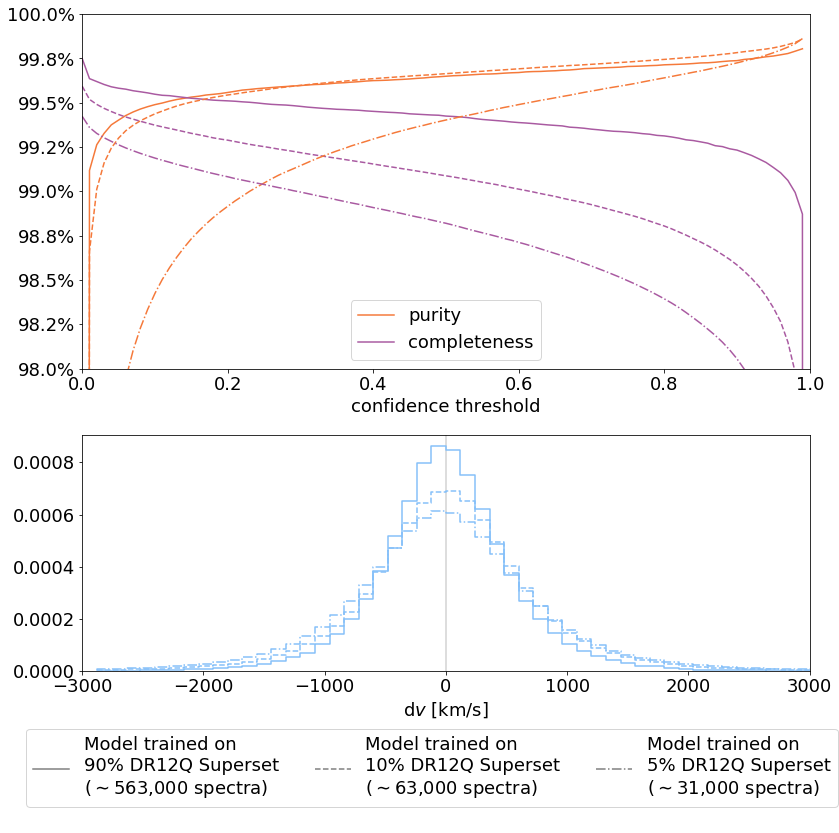

In [12]:
filename = '../plots/qn_performance_vs_training_set_size_2panel.pdf'

plot.plot_qn_model_compare(data_table,strategies,filename=filename,
                           dv_max=dv_max,nydec=1,figsize=(12,12),
                           ymin=0.98,ymax=1.,verbose=True,npanel=2,
                           norm_dvhist=True,c_th=c_th_values,show_std=False,
                           strategies_to_plot=strategies_to_plot,
                           bottom_edge_offset=0.13
                          )
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:35: RuntimeWarning: invalid value encountered in long_scalars
  pur = pur_num/pur_denom
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:293: RuntimeWarning: invalid value encountered in greater
  ind = np.where(pur>com)[0][0]
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:328: RuntimeWarning: invalid value encountered in greater
  ind = np.where(mean_pur>mean_com)[0][0]
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Strategy QN_90:
Crossover occurs at:
cth: [0.13 0.14 0.15 0.16]
pur: [0.9952 0.9953 0.9953 0.9954]
com: [0.9954 0.9953 0.9953 0.9952]
QN_90 has median velocity error -7.824 and standard deviation 618.487

Strategy QN_10:
Crossover occurs at:
cth: [0.06 0.07 0.08 0.09]
pur: [0.9934 0.9937 0.994  0.9942]
com: [0.9942 0.9941 0.994  0.9938]
QN_10 has median velocity error 18.374 and standard deviation 793.175

Strategy QN_5:
Crossover occurs at:
cth: [0.23 0.24 0.25 0.26]
pur: [0.99   0.9902 0.9905 0.9907]
com: [0.9906 0.9905 0.9904 0.9903]
QN_5 has median velocity error -18.339 and standard deviation 909.928



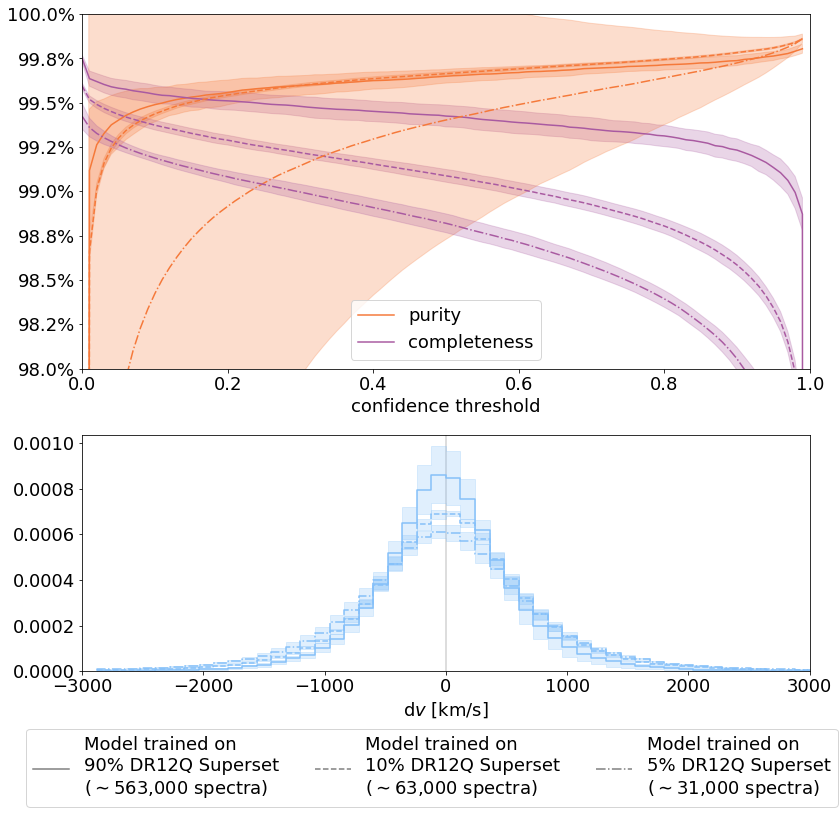

In [13]:
filename = '../plots/qn_performance_vs_training_set_size_2panel_shaded.pdf'

plot.plot_qn_model_compare(data_table,strategies,filename=filename,
                           dv_max=dv_max,nydec=1,figsize=(12,12),
                           ymin=0.98,ymax=1.,verbose=True,npanel=2,
                           norm_dvhist=True,c_th=c_th_values,show_std=True,
                           strategies_to_plot=strategies_to_plot,
                           bottom_edge_offset=0.13
                          )
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:35: RuntimeWarning: invalid value encountered in long_scalars
  pur = pur_num/pur_denom
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:293: RuntimeWarning: invalid value encountered in greater
  ind = np.where(pur>com)[0][0]
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:328: RuntimeWarning: invalid value encountered in greater
  ind = np.where(mean_pur>mean_com)[0][0]


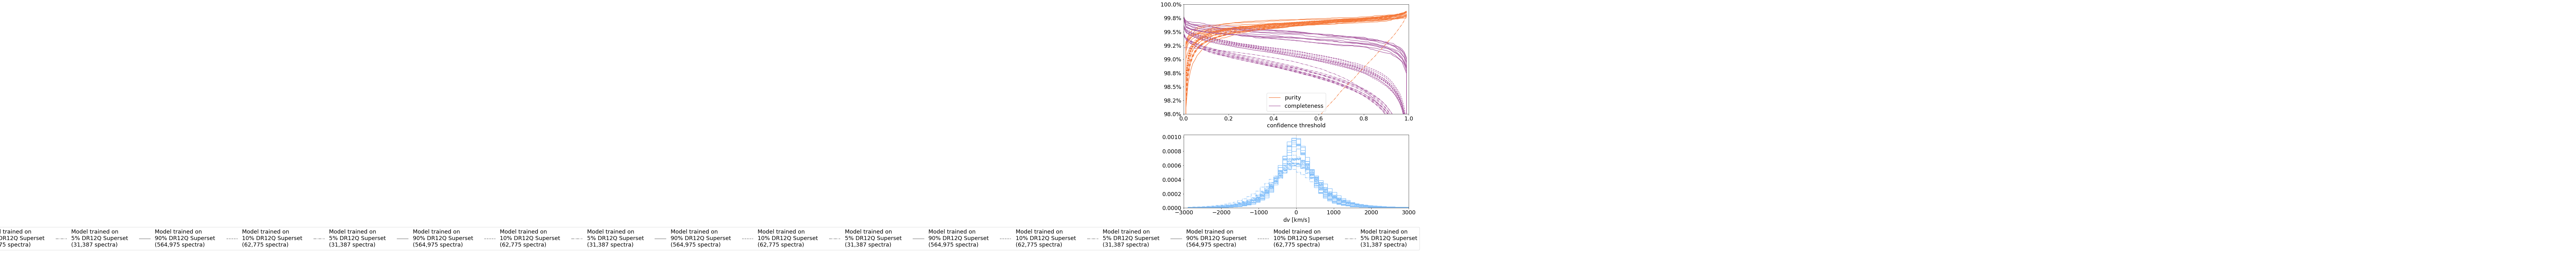

In [14]:
filename = '../plots/qn_performance_vs_training_set_size_2panel_individual.pdf'

plot.plot_qn_model_compare(data_table,strategies,filename=filename,
                           dv_max=dv_max,nydec=1,figsize=(12,12),
                           ymin=0.98,ymax=1.,verbose=False,npanel=2,
                           norm_dvhist=True,c_th=c_th_values,show_std=False,
                           bottom_edge_offset=0.13
                          )
plt.show()

In [ ]:
models_to_include = {0.9: [0,1,2,3,4,5,6,7,8,9],
                     0.1: [0,1,2,3,4,5,6,7,8,9],
                     0.05: [0,1,2,3,4,5,6,7,9],
                    }

strategies_to_plot_excl = {}
for pc_dr12 in pc_dr12_values:
    
    p = pc_dr12/100
    name = 'Trained on {:.0%}\nDR12Q Superset\n'.format(p)
    name += r'({:,} spectra)'.format(training_set_sizes[p])
    
    s = 'QN_{}'.format(pc_dr12)
    strategies_to_plot_excl[s] = {'strategies': ['QN_{} {}'.format(pc_dr12,i) for i in models_to_include[p]], 'ls': ls[s], 'n': name}

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:35: RuntimeWarning: invalid value encountered in long_scalars
  pur = pur_num/pur_denom
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:293: RuntimeWarning: invalid value encountered in greater
  ind = np.where(pur>com)[0][0]
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:328: RuntimeWarning: invalid value encountered in greater
  ind = np.where(mean_pur>mean_com)[0][0]
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Strategy QN_90:
Crossover occurs at:
cth: [0.13 0.14 0.15 0.16]
pur: [0.9952 0.9953 0.9953 0.9954]
com: [0.9954 0.9953 0.9953 0.9952]
QN_90 has median velocity error -7.824 and standard deviation 618.487

Strategy QN_10:
Crossover occurs at:
cth: [0.06 0.07 0.08 0.09]
pur: [0.9934 0.9937 0.994  0.9942]
com: [0.9942 0.9941 0.994  0.9938]
QN_10 has median velocity error 18.374 and standard deviation 793.175

Strategy QN_5:
Crossover occurs at:
cth: [0.05 0.06 0.07 0.08]
pur: [0.9917 0.9922 0.9926 0.9929]
com: [0.9927 0.9925 0.9923 0.9922]
QN_5 has median velocity error -6.418 and standard deviation 902.280



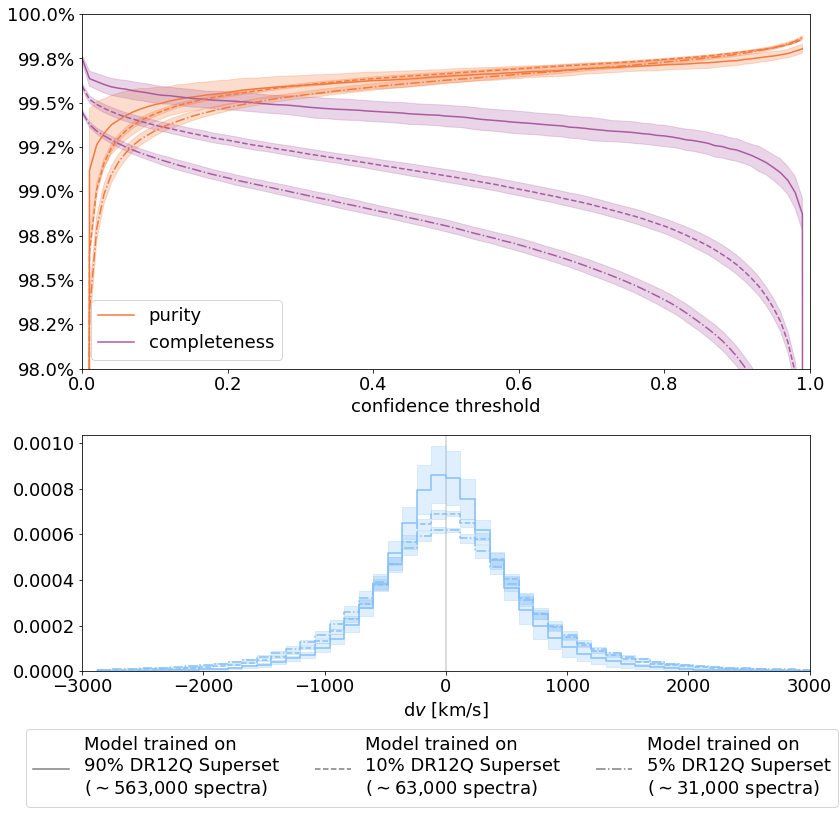

In [16]:
filename = '../plots/qn_performance_vs_training_set_size_2panel_shaded_exclude_outliers.pdf'

plot.plot_qn_model_compare(data_table,strategies,filename=filename,
                           dv_max=dv_max,nydec=1,figsize=(12,12),
                           ymin=0.98,ymax=1.,verbose=True,npanel=2,
                           norm_dvhist=True,c_th=c_th_values,show_std=True,
                           strategies_to_plot=strategies_to_plot_excl,
                           bottom_edge_offset=0.13
                          )
plt.show()

In [ ]:
filename = '../plots/qn_performance_vs_training_set_size_2panel_exclude_outliers.pdf'

plot.plot_qn_model_compare(data_table,strategies,filename=filename,
                           dv_max=dv_max,nydec=1,figsize=(12,12),
                           ymin=0.98,ymax=1.,verbose=True,npanel=2,
                           norm_dvhist=True,c_th=c_th_values,show_std=True,
                           strategies_to_plot=strategies_to_plot_excl,
                           bottom_edge_offset=0.13
                          )
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:35: RuntimeWarning: invalid value encountered in long_scalars
  pur = pur_num/pur_denom
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:293: RuntimeWarning: invalid value encountered in greater
  ind = np.where(pur>com)[0][0]
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:328: RuntimeWarning: invalid value encountered in greater
  ind = np.where(mean_pur>mean_com)[0][0]
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Strategy QN_90:
Crossover occurs at:
cth: [0.13 0.14 0.15 0.16]
pur: [0.9952 0.9953 0.9953 0.9954]
com: [0.9954 0.9953 0.9953 0.9952]
QN_90 has median velocity error -7.824 and standard deviation 618.487

Strategy QN_10:
Crossover occurs at:
cth: [0.06 0.07 0.08 0.09]
pur: [0.9934 0.9937 0.994  0.9942]
com: [0.9942 0.9941 0.994  0.9938]
QN_10 has median velocity error 18.374 and standard deviation 793.175

Strategy QN_5:
Crossover occurs at:
cth: [0.05 0.06 0.07 0.08]
pur: [0.9917 0.9922 0.9926 0.9929]
com: [0.9927 0.9925 0.9923 0.9922]
QN_5 has median velocity error -6.418 and standard deviation 902.280

Strategy outlier:
Crossover occurs at:
cth: [0.73 0.74 0.75 0.76]
pur: [0.9855 0.9859 0.9862 0.9867]
com: [0.9862 0.986  0.9857 0.9855]
outlier has median velocity error -140.497 and standard deviation 969.070



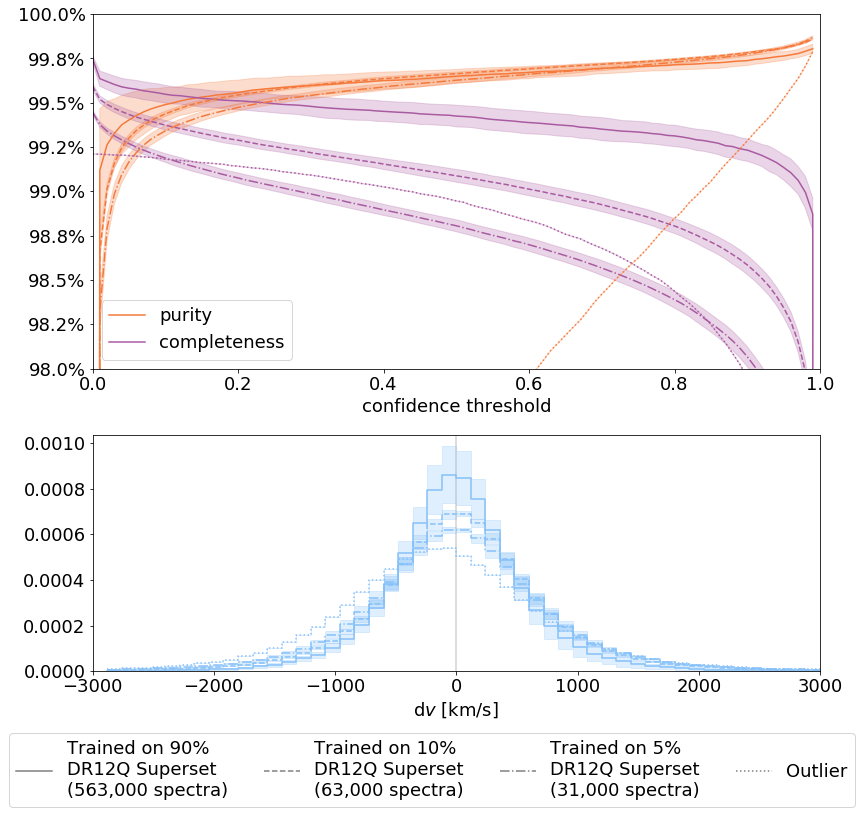

In [17]:
strategies_to_plot_excl['outlier'] = {'strategies': ['QN_5 8'], 'ls': ':', 'n': 'Outlier'}
filename = '../plots/qn_performance_vs_training_set_size_2panel_shaded_exclude_outliers_plusindiv.pdf'

plot.plot_qn_model_compare(data_table,strategies,filename=filename,
                           dv_max=dv_max,nydec=1,figsize=(12,12),
                           ymin=0.98,ymax=1.,verbose=True,npanel=2,
                           norm_dvhist=True,c_th=c_th_values,show_std=True,
                           strategies_to_plot=strategies_to_plot_excl,
                           bottom_edge_offset=0.13
                          )
plt.show()